# Analyze Human Body Temperature Using EDA:  Submitted by Ahrim Han (2019/2/22)

# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37 C or 98.6 F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
from scipy import stats
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
sns.set()

In [3]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


### 1. Is the distribution of body temperatures normal?
We first draw the histogram.

Text(0.5, 1.0, 'Histogram: Body Temperature')

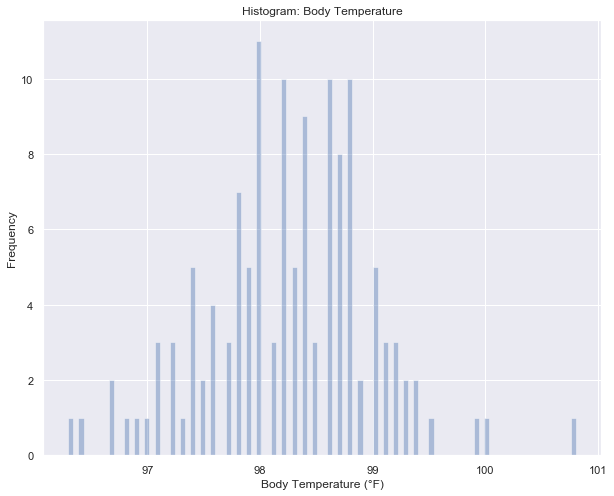

In [5]:
#histogram
sns.set(rc={'figure.figsize':(10,8)})

#area of the PDF (Probability Density Function) becomes 1, when settting normed (density) = 1
#plt.hist(df['temperature'], bins=100, density=True)

#kernel density estimate (KDE)
sns.distplot(df['temperature'], kde=False, bins = 100)

plt.xlabel('Body Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Histogram: Body Temperature')

The sample distribution resembles the normal distribution.

To confirm the normal distribution, we run the normality test to know whether a sample differs from a normal distribution. This function `normaltest` tests the null hypothesis that a sample comes from a normal distribution.

In [6]:
alpha = 0.05
k2, p = stats.normaltest(df['temperature'])
print('p-value = {:.10f}'.format(p))

# null hypothesis (H0): x comes from a normal distribution
if p < alpha:
    print('The null hypothesis can be rejected.')
else:
    print('The null hypothesis cannot be rejected. This is a normal distribution.')

p-value = 0.2587479863
The null hypothesis cannot be rejected. This is a normal distribution.


We defined the `ecdf` (empirical cumulative distribution function). We also simulate a normal distribution of the mean, std, and size of 100 times. At the end, we compared the two plots. The graph shows that the data is a normal distribution.

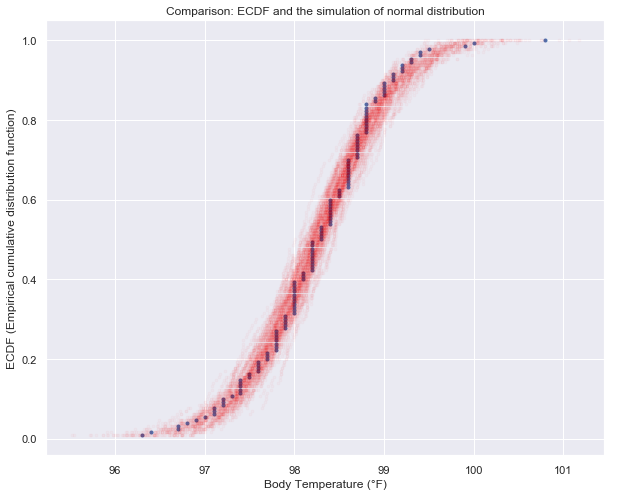

In [7]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

#ecdf (empirical cumulative distribution function)
x, y = ecdf(df['temperature'])
_ = plt.plot(x, y, marker='.', linestyle='none')

#Simulate a normal distribution of the mean, std, and size of 100 times
m, s, n = np.mean(df['temperature']), np.std(df['temperature']), len(df['temperature'])
for i in range(100):
    sample = np.random.normal(m, s, n)
    x, y = ecdf(sample)
    _ = plt.plot(x, y, marker = '.', alpha = 0.02, linestyle = 'none', color = 'red')

_ = plt.xlabel('Body Temperature (°F)')
_ = plt.ylabel('ECDF (Empirical cumulative distribution function)')
plt.title('Comparison: ECDF and the simulation of normal distribution')
plt.show()

### 2. Is the sample size large? Are the observations independent?

**Sample size**

In [8]:
print("Sample size:", len(df))

Sample size: 130


The size of the data is greater than 30 and the sample size is large enough.

**Independent observations**

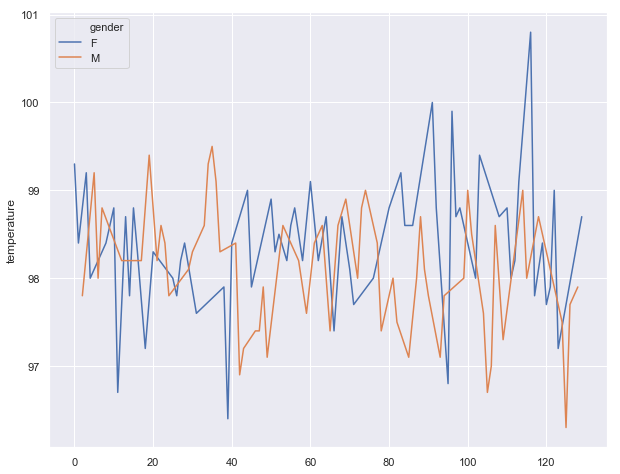

In [9]:
sns.lineplot(x=df.index, y="temperature",
             hue="gender", data=df)

The observations for temperature are independent because one person's temperature does not affect another person's temperature. Furthermore, there is no correlation in the temperatures between males and females.

### 3. Is the true population mean really 98.6 degrees F?

**1. Bootstrap hypothesis test**

**Step1:** The null and alternative hypothesis are stated:  
- $H_0$: $\mu$ = 98.6  
- $H_1$: $\mu$ $\neq$ 98.6  

We chose the significance level at 5% ($\alpha$ = 0.05).  

**Step 2:** We will use the population mean as our test statistic. The **observed value of the test statistic (e.g., population mean)** is `np.mean(df['temperature'])`.

In [10]:
print("Mean of sample: ")
print(np.mean(df['temperature']))

Mean of sample: 
98.24923076923078


**Step 3:** We shifted the sample data to have the mean of 98.6.

In [11]:
temp_shifted = df['temperature'] - np.mean(df['temperature']) + 98.6
print("Mean of shifted sample: ")
print(np.mean(temp_shifted))

Mean of shifted sample: 
98.59999999999992


**Step 4:** We now take the bootstrap replicates (simulated data sets) of the shifted data.
We take out 10,000 observations at random.
We compute the test statistic for each simulated data set.

In [12]:
# We generate many sets of simulated data assuming the null hypothesis is true.
def bootstrap_replicate_1d(data, func):
    """Generate a single bootstrap replicate."""
    bs_rep = np.random.choice(data, size=len(data))
    #print(len(data))
    #print(bs_rep)
    return func(bs_rep)

def draw_bs_reps(data, func, size):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

#We compute the test statistic for each simulated data set.
bootstrap_replicates = draw_bs_reps(temp_shifted, np.mean, 10000)
print(bootstrap_replicates)

[98.56692308 98.74230769 98.66153846 ... 98.56615385 98.53692308
 98.58      ]


**Step 5:**
The p-value is the probability of getting something more extreme than what we observed.  
The p-value is computed as the fraction of replicates that are less than the observed temperature.

In [13]:
#98.25 (np.mean(df['temperature'])) is 98.60 - 98.25 = 0.35 (np.mean(shifted) - np.mean(df['temperature'])) units away from the null hypothesis.

# (check) Compute fraction of replicates that are less than the observed temperature: p_val
p_val = np.sum(bootstrap_replicates <= np.mean(df['temperature'])) / len(bootstrap_replicates)

print('p-value = {:.10f}'.format(p_val))

p-value = 0.0000000000


==> Since p-value is 0, the null hypothesis is rejected. True population mean is unlikely to be 98.6 degrees F.

**2. Frequentist statistical testing**

We should use **one-sample test** since we compare a sample to a number, not comparing two different groups.  
Here I summarize the relevant libraries.  
* `scipy.stats.ttest_1samp`: calculate the T-test for the mean of ONE group of score (one-sample test)
* `scipy.stats.ttest_ind`: calculate the T-test for the means of two independent samples of scores
* `scipy.stats.ttest_rel`: calculate the T-test on TWO RELATED samples of scores, a and b

Also, we would use **two-tailed test** becasue we want to test if the sample mean is either far greater or far smaller than 98.6 degrees. Since the sample size is 130, we can use [**z-test (z statistic)**](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/).  

* **z-test**  

In [14]:
#z = (x – μ) / (σ / √n)
n = len(df['temperature'])
sample_mean = np.mean(df['temperature'])
sample_std = np.std(df['temperature'])

z = (sample_mean - 98.6) / (sample_std / np.sqrt(n))
#p-value
p_val = stats.norm.cdf(z) * 2 #multiplication by 2 because we are doing two-tailed test

print("z: {:.10f}, p-value: {:.10f}".format(z, p_val))

z: -5.4759252021, p-value: 0.0000000435


==> Since the $p-$value is much smaller than $\alpha$ = 0.05, we reject the null hypothesis that the true population mean is 98.6 degress.

* **t-test**

In [15]:
t, p_val = stats.ttest_1samp(df['temperature'], 98.6)
print("t: {:.10f}, p-value: {:.10f}".format(t, p_val))

t: -5.4548232924, p-value: 0.0000002411


The results for t-test are quite similar to that for z-test. This is because the sample size is large. As the number of samples increases, the t-distribution will approach the normal z-distribution.

The $p$-value obtained from t-test is about $5$ times greater than that obtained from z-test, but is still much smaller than 0.05. Therefore, we have the same conclusions as the z-test results.


==> Since the $p-$value is much smaller than $\alpha$ = 0.05, we reject the null hypothesis that the true population mean is 98.6 degress.

### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

In [16]:
#Draw a sample of 10
sample = np.random.choice(df['temperature'], 10)

#Run z test
z = (np.mean(sample) - 98.6) / np.std(sample)/ np.sqrt(len(sample))
p_val1 = stats.norm.cdf(z) * 2
print("z: {:.10f}, p-value: {:.10f}".format(z, p_val1))

#Run t test
t, p_val2 = stats.ttest_1samp(sample, 98.6)
print("t: {:.10f}, p-value: {:.10f}".format(t, p_val2))

z: -0.2605327627, p-value: 0.7944528467
t: -2.4716308053, p-value: 0.0354752275


**Which one is the correct one to use?**

It is known that we must use the t-distribution table when working problems when the population standard deviation ($\sigma$) is not known and the sample size is small (n < 30).  
Because the **sample size is small, t-test is the correct one to use**.

The z-test is best used for greater than 30 samples because, under the central limit theorem, as the number of samples gets larger, the samples are considered to be approximately normally distributed.

**What do you notice? What does this tell you about the difference in application of the t and z statistic?**  

For one sample of 10, the difference between z and t test are larger, and can sometimes result in different conclusions depending on the alpha. Over many small samples, t test is more accurate than z test. 

### 5. At what temperature should we consider someone's temperature to be "abnormal"?

**Bootstrap approach**

In [17]:
# Bootstrap approach: 95% confidence interval
bs_ci = np.percentile(bootstrap_replicates ,[2.5, 97.5])

print('Bootstrap approach:')
print('95% confidence interval range: [{:.3f}, {:.3f}]'.format(bs_ci[0], bs_ci[1]))
print('Margin of error is {:.1f} degrees.'.format((bs_ci[1]-bs_ci[0])/2))

Bootstrap approach:
95% confidence interval range: [98.475, 98.726]


**Frequentist approach**

In [18]:
#parameter method: whether the confidence interval will be calculating using the t distribution or a z/normal distribution.
#confidence interval range: lower and upper bounds
def CI_printout(sample, interval = 0.95, method = 't'):
    mean_val = sample.mean()
    n = sample.count()
    stdev = sample.std()    
    if method == 't':
        test_stat = stats.t.ppf((interval + 1)/2, n)        
    elif method == 'z':
        test_stat = stats.norm.ppf((interval + 1)/2)
    lower_bound = mean_val - test_stat * stdev / np.sqrt(n)
    upper_bound = mean_val + test_stat * stdev / np.sqrt(n)
    return lower_bound, upper_bound

lower_bound, upper_bound = CI_printout(df['temperature'], 0.95, 'z')

print('Frequentist approach:')
print('95% confidence interval range: [{:.3f}, {:.3f}]'.format(lower_bound, upper_bound))

Frequentist approach:
95% confidence interval range: [98.123, 98.375]


==> So, we consider the normal temperature to be in the range from 98.123 to 98.375 with a confidence level of 95%. Any value of temperature beyond this range can be considered abnormal.

Please note that we also can use the provided library as follows.

In [19]:
import statsmodels.stats.api as sms
sms.DescrStatsW(df['temperature']).tconfint_mean()

(98.12200290560803, 98.3764586328535)

### 6. Is there a significant difference between males and females in normal temperature?

First, we find the mean normal temperature for both malies and females.

In [20]:
means = df.groupby("gender")["temperature"].mean()
means

gender
F    98.393846
M    98.104615
Name: temperature, dtype: float64

It seems that the mean female temeprature slightly higher than that for males.  
We visualise the distribution of temperatures for both males and females. 

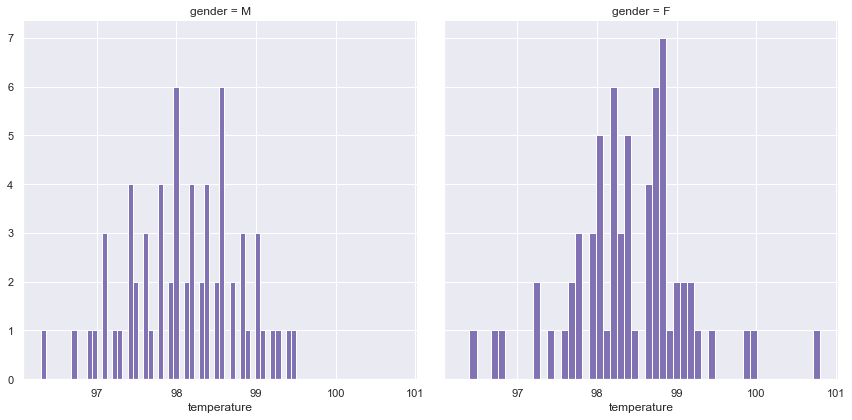

In [21]:
g = sns.FacetGrid(df, col="gender", col_order=["M", "F"], height=6, aspect=1)
g = g.map(plt.hist, "temperature", bins=50, color="m")

Now we perform a hypothesis test (two-sample test and one-tailed) by assuming male and female samples are independent.  

- $H_0$: There is **no difference** in temperatures between male and female.
- $H_1$: There **exist difference** in temperatures between male and female.
- $\alpha$ = 0.05

**Bootstrap approach**

In [22]:
male_sample = df.loc[(df['gender'] == 'M')]['temperature']
female_sample = df.loc[(df['gender'] == 'F')]['temperature']

temp_diff_perm = np.empty(10000)
for i in range(10000):
    sample_perm = np.random.permutation(df['temperature'])
    perm_male = sample_perm[:len(male_sample)]
    perm_female = sample_perm[len(male_sample):]
    temp_diff_perm[i] = np.mean(perm_male) - np.mean(perm_female)
    

#bootstrap p-value is, in general, simply the proportion of the bootstrap test statistics that are more extreme than the observed test statistic
#(check-comparision) p_val = np.sum(bootstrap_replicates <= np.mean(df['temperature'])) / len(bootstrap_replicates)

p_val = np.sum(abs(temp_diff_perm) >= abs(np.mean(male_sample)-np.mean(female_sample))) / len(temp_diff_perm)
print('p-value = {:.10f}'.format(p_val))

p-value = 0.0235000000


==> Since p-value is smaller than the significance level 0.05, the null hypothesis is rejected. There exist difference in temperatures betwenn male and female.

**Frequentist approach**

* **z-test**   

In [23]:
t, p = stats.ttest_ind(male_sample, female_sample)
print("t: {:.10f}, p-value: {:.10f}".format(t, p_val))

t: -2.2854345382, p-value: 0.0235000000


==> Since p-value is smaller than the significance level 0.05, the null hypothesis is rejected. There exist difference in temperatures betwenn male and female.

### Conclusion

For more than 120 years, the mean normal body temperature was held to be 98.6 F.  
However, based on the dataset of 130 samples, we showed that the **value of the mean temperature is not 98.6 F**.   
We consider the normal temperature to be in the range from 98.123 to 98.375 with a confidence level of 95%. Any value of temperature beyond this range can be considered abnormal.  
We also found that there exist difference in temperatures betwenn male and female.